# greedyアルゴリズム
## $i = {\rm argmax}_i [\mu_i] = {\rm argmax}_i \left[\cfrac{\sum_{t_i} r_i } {t_i} \right]$
# 楽観的初期値法
## $i = {\rm argmax}_i [\mu'_i] = {\rm argmax}_i \left[\cfrac{\sum_{t_i} r_i + Kr_{sup}} {t_i+K} \right]$
# UCB1
## $i = {\rm argmax}_i [\mu_i + U_i] = {\rm argmax}_i \left[ \cfrac{\sum_{t_i} r_i}{t_i} + R \sqrt{\cfrac{2\ln\left(\sum_i t_i\right)}{t_i}} \right]$

In [1]:
# import library
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# agent setting
class Enviroment:
    def __init__(self, iter_num=1000, init_play_num=100, agent_num=1000):
        self.iter_num = iter_num #試行回数
        self.init_play_num = init_play_num #最初に各スロットを試す回数
        self.agent_num = agent_num #エージェント数
        self.play_num = iter_num #プレイ回数
        self.prob_slot = [0.1, 0.2, 0.3, 1] #各スロットの当たり確率
        self.slot_reward = [500, 500, 500, 100] #各スロットで当たった時の報酬
        self.slot_num = len(self.slot_reward)
        self.play_slot_num = np.zeros((self.slot_num,agent_num)) #あるエージェントがそのスロットを選択した回数
        self.ave_reward = np.zeros((self.slot_num,agent_num))
        self.agent_num_of_slot = np.zeros((self.slot_num,iter_num)) #各試行においてそのスロットを選んだエージェント数
        self.unselected_slot_is = True #全てのスロットで遊んだかどうかを記憶しておくフラグ
        self.u_s = np.zeros(self.slot_num) #UCB値をストックする配列
        
    def add_init_play_num(self):
        self.play_num = iter_num - init_play_num #プレイ回数
        # どのスロットも初期プレイ回数分は必ずプレイする
        self.play_slot_num = self.play_slot_num + self.init_play_num
            
    def get_init_play_num(self):
        return self.init_play_num
    
    def get_slot_reward(self, slot_no):
        return self.slot_reward[slot_no]
    
    def get_ave_reward(self, slot_no, agent_no):
        return self.ave_reward[slot_no, agent_no]
    
    def set_ave_reward(self, slot_no, agent_no, ave_reward):
        self.ave_reward[slot_no, agent_no] = ave_reward
        
    def get_agent_num_of_slot(self, slot_no, iter_no):
        return self.agent_num_of_slot[slot_no, iter_no]
    
    def set_agent_num_of_slot(self, slot_no, agent_no, value):
        self.agent_num_of_slot[slot_no, agent_no] = value
        
    def get_play_slot_num(self, slot_no, agent_no):
        return self.play_slot_num[slot_no, agent_no]
    
    def set_play_slot_num(self, slot_no, agent_no, value):
        self.play_slot_num[slot_no, agent_no] = value
        
    def get_play_slot_tot_num(self, agent_no):
        return self.play_slot_num[:, agent_no]
        
    def get_max_ave_reward_slot(self, agent_no):
        return np.argmax(self.ave_reward[:, agent_no])
    
    def get_max_reward(self):
        return max(self.slot_reward[:])
    
class Learn:
    def __init__(self, iter_num=1000, init_play_num=100, agent_num=1000, policy='greedy'):
        if policy not in ['greedy', 'oivm', 'ucb1']:
            raise ValueError('Unknown policy')
        self.policy = policy
        self.env = Enviroment(iter_num, init_play_num, agent_num)
        if self.policy == 'greedy'or self.policy == 'oivm':
            self.env.add_init_play_num()
        
    def play_slot(self, slot_no):
        #当たったら報酬を獲得する
        if np.random.rand() <= self.env.prob_slot[slot_no]:
            return self.env.slot_reward[slot_no]
        else:
            return 0
        
    def ucb1_algo(self, agent_no):
        '''選んだことのない腕があればそのうちの一つを選択する'''
        for slot_no in range(self.env.slot_num):
            if self.env.get_play_slot_num(slot_no, agent_no) == 0:
                return slot_no
        return None
        
    def pre_play_a_slot(self, slot_no, agent_no):
        reward = 0 # reset reward
        #初期試行回数分試す
        for play_num in range(self.env.init_play_num):
            if self.policy == 'greedy':
                reward += self.play_slot(slot_no)
            elif self.policy == 'oivm':
                reward += self.env.get_max_reward()
        reward = reward / self.env.init_play_num #平均値を求める
        self.env.set_ave_reward(slot_no, agent_no, reward) #平均報酬を記録

    def pre_play(self, agent_no):
        #各スロットに対して初期試行
        for slot_no in range(self.env.slot_num):
            self.pre_play_a_slot(slot_no, agent_no)
            
    def calc_reward(self, slot_no, agent_no):
        # 今選んだそのスロットから得られた報酬 + 今までそのスロットから得られた平均報酬 * そのスロットを選んだ回数
        numerator = self.play_slot(slot_no) + self.env.get_ave_reward(slot_no, agent_no) * self.env.get_play_slot_num(slot_no, agent_no)
        # 今までそのスロットを選んだ回数 + 1
        demoninator = self.env.get_play_slot_num(slot_no, agent_no) + 1
        return numerator / demoninator
    
    def calc_ucb(self, slot_no, agent_no):
        first_term = self.env.get_ave_reward(slot_no, agent_no)
        # 払い戻し額の最大値と最小値の差
        numerator = 2 * np.log( np.sum(self.env.get_play_slot_tot_num(agent_no)) )
        demoninator = self.env.get_play_slot_num(slot_no, agent_no)
        second_term = self.env.get_slot_reward(slot_no) * np.sqrt( numerator / demoninator )
        return first_term + second_term
    
    def select_slot_machine(self, agent_no):
        if self.policy == 'greedy' or self.policy == 'oivm':
            return self.env.get_max_ave_reward_slot(agent_no) #現在平均報酬が最大のスロットを選ぶ
        elif self.policy == 'ucb1':
            if self.env.unselected_slot_is is True:
                return self.ucb1_algo(agent_no)
            else:
                for slot_no in range(self.env.slot_num):
                    self.env.u_s[slot_no] = self.calc_ucb(slot_no, agent_no)
                return np.argmax(self.env.u_s)
    
    def incremant_agent_count(self, select_slot_no, play_num, agent_no):
        if self.policy == 'greedy' or self.policy == 'oivm':
            tot_play_num = self.env.get_init_play_num() + play_num
            agent_num_of_slot = self.env.get_agent_num_of_slot(select_slot_no, self.env.get_init_play_num()+play_num) + 1
        elif self.policy == 'ucb1':
            tot_play_num = play_num
            agent_num_of_slot = self.env.get_agent_num_of_slot(select_slot_no, play_num) + 1
        
        self.env.set_agent_num_of_slot(
            select_slot_no,
            tot_play_num,
            agent_num_of_slot
        ) # そのスロットを選んだエージェント数を1増やす        
        
    def play_one_agent(self, agent_no):
        if self.policy == 'greedy' or self.policy == 'oivm':
            self.pre_play(agent_no)
        #プレイ回数だけスロットを選んで報酬を計算する
        for play_num in range(self.env.play_num):
            select_slot_no = self.select_slot_machine(agent_no)
            
            self.incremant_agent_count(select_slot_no, play_num, agent_no)
                
            self.env.set_ave_reward(
                select_slot_no,
                agent_no,
                self.calc_reward(select_slot_no, agent_no)
            ) # 平均報酬を更新
            self.env.set_play_slot_num(select_slot_no, agent_no, self.env.get_play_slot_num(select_slot_no, agent_no)+1) #現在の試行回数を1増やす
            if self.policy == 'ucb1':
                if self.ucb1_algo(agent_no) is None:
                    self.env.unselected_slot_is = False
    
    def learn_for_all_agent(self):
        # エージェントの数だけ試す
        pbar = tqdm(total=self.env.agent_num)
        for agent_no in range(self.env.agent_num):
            pbar.update(1)
            self.env.unselected_slot_is = True
            self.play_one_agent(agent_no)
        pbar.close()
            
    def calc_agent_num_of_slot(self):
        # 最終的に各スロットを選んだ人数を求める
        select_slot = np.zeros(self.env.slot_num)
        for agent_no in range(self.env.agent_num):
            select_slot_no = self.env.get_max_ave_reward_slot(agent_no)
            select_slot[select_slot_no] += 1
        print(select_slot)
        
    def view_setting(self):
        # 結果のプロット
        plt.rcParams["font.family"] = "serif"
        #plt.rcParams["figure.figsize"] = [20, 12] # グラフのサイズを指定
        plt.rcParams['font.size'] = 14 #フォントサイズを設定 default : 12
        plt.rcParams['xtick.labelsize'] = 14 # 横軸のフォントサイズ
        plt.rcParams['ytick.labelsize'] = 14 # 縦軸のフォントサイズ
        plt.xlabel("play num")
        plt.ylabel("agent num")
        if self.policy == 'greedy':
            plt.title("greedy({0})".format(self.env.init_play_num))
        elif self.policy == 'oivm':
            plt.title("Optimistic initial value method")
        elif self.policy == 'ucb1':
            plt.title("UCB1")
        #plt.tick_params(labelsize=14)
        
    def plot_result(self):
        self.view_setting()
        for slot_no in range(self.env.slot_num):
            plt.plot(self.env.agent_num_of_slot[slot_no,:], linewidth=3, label='slot{0}'.format(slot_no))
        plt.legend()
        plt.tight_layout()
        plt.show()

100%|██████████| 1000/1000 [16:00<00:00,  1.04it/s]


[   0.    0. 1000.    0.]


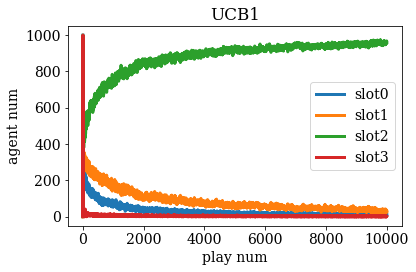

In [3]:
def main():
    run = Learn(iter_num=10000, init_play_num=10, agent_num=1000, policy='ucb1')
    run.learn_for_all_agent()
    run.calc_agent_num_of_slot()
    run.plot_result()

if __name__ == '__main__':
    main()